# MadMiner physics tutorial (part 3C)

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In part 3C of this tutorial we will train a third neural estimator: this time of the likelihood function itself (rather than its ratio). We assume that you have run part 1 and 2A of this tutorial. If, instead of 2A, you have run part 2B, you just have to load a different filename later.

## Preparations

In [1]:
import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

from madminer.sampling import SampleAugmenter
from madminer import sampling
from madminer.ml import LikelihoodEstimator

In [2]:
# MadMiner output
logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. Make (unweighted) training and test samples with augmented data

At this point, we have all the information we need from the simulations. But the data is not quite ready to be used for machine learning. The `madminer.sampling` class `SampleAugmenter` will take care of the remaining book-keeping steps before we can train our estimators:

First, it unweights the samples, i.e. for a given parameter vector `theta` (or a distribution `p(theta)`) it picks events `x` such that their distribution follows `p(x|theta)`. The selected samples will all come from the event file we have so far, but their frequency is changed -- some events will appear multiple times, some will disappear.

Second, `SampleAugmenter` calculates all the augmented data ("gold") that is the key to our new inference methods. Depending on the specific technique, these are the joint likelihood ratio and / or the joint score. It saves all these pieces of information for the selected events in a set of numpy files that can easily be used in any machine learning framework.

In [3]:
#sampler = SampleAugmenter("data/lhe_data_shuffled.h5")
sampler = SampleAugmenter('data/delphes_data_shuffled.h5')

16:11 madminer.analysis.da INFO    Loading data from data/delphes_data_shuffled.h5
16:11 madminer.utils.inter INFO    HDF5 file does not contain nuisance parameters information
16:11 madminer.utils.inter INFO    HDF5 file does not contain finite difference information
16:11 madminer.utils.inter INFO    HDF5 file does not contain systematic information
16:11 madminer.analysis.da INFO    Found 2 parameters
16:11 madminer.analysis.da INFO      0: CWL2 (LHA: dim6 2, Power: 2, Range: (-20.0, 20.0))
16:11 madminer.analysis.da INFO      1: CPWL2 (LHA: dim6 5, Power: 2, Range: (-20.0, 20.0))
16:11 madminer.analysis.da INFO    Did not find nuisance parameters
16:11 madminer.analysis.da INFO    Found 6 benchmarks
16:11 madminer.analysis.da INFO    Found 3 observables
16:11 madminer.analysis.da INFO    Found 4190 events
16:11 madminer.analysis.da INFO      4190 signal events sampled from benchmark sm
16:11 madminer.analysis.da INFO      0 signal events sampled from benchmark w
16:11 madminer.anal

The `SampleAugmenter` class defines five different high-level functions to generate train or test samples:
- `sample_train_plain()`, which only saves observations x, for instance for histograms or ABC;
- `sample_train_local()` for methods like SALLY and SALLINO, which will be demonstrated in the second part of the tutorial;
- `sample_train_density()` for neural density estimation techniques like MAF or SCANDAL;
- `sample_train_ratio()` for techniques like CARL, ROLR, CASCAL, and RASCAL, when only theta0 is parameterized;
- `sample_train_more_ratios()` for the same techniques, but with both theta0 and theta1 parameterized;
- `sample_test()` for the evaluation of any method.

For the arguments `theta`, `theta0`, or `theta1`, you can (and should!) use the helper functions `benchmark()`, `benchmarks()`, `morphing_point()`, `morphing_points()`, and `random_morphing_points()`, all defined in the `madminer.sampling` module.

Here we'll train a likelihood estimator with the SCANDAL method, so we focus on the `extract_samples_train_density()` function. We'll sample the numerator hypothesis in the likelihood ratio with 1000 points drawn from a Gaussian prior, and fix the denominator hypothesis to the SM.

Note the keyword `sample_only_from_closest_benchmark=True`, which makes sure that for each parameter point we only use the events that were originally (in MG) generated from the closest benchmark. This reduces the statistical fluctuations in the outcome quite a bit.

In [4]:
x, theta, t_xz, _ = sampler.sample_train_density(
    theta=sampling.random_morphing_points(10000, [("gaussian", 0.0, 0.5), ("gaussian", 0.0, 0.5)]),
    n_samples=500000,
    folder="./data/samples",
    filename="train_density",
    sample_only_from_closest_benchmark=True,
)

16:11 madminer.sampling.sa INFO    Extracting training sample for non-local score-based methods. Sampling and score evaluation according to ('random_morphing_points', (10000, [('gaussian', 0.0, 0.5), ('gaussian', 0.0, 0.5)]))
16:11 madminer.sampling.sa INFO    Starting sampling serially
16:11 madminer.sampling.sa WARNING Large statistical uncertainty on the total cross section when sampling from theta = [-0.7189592 -0.6616956]: (0.000699 +/- 0.000338) pb (48.35842327320853 %). Skipping these warnings in the future...
16:11 madminer.sampling.sa INFO    Sampling from parameter point 500 / 10000
16:12 madminer.sampling.sa INFO    Sampling from parameter point 1000 / 10000
16:12 madminer.sampling.sa INFO    Sampling from parameter point 1500 / 10000
16:12 madminer.sampling.sa INFO    Sampling from parameter point 2000 / 10000
16:12 madminer.sampling.sa INFO    Sampling from parameter point 2500 / 10000
16:12 madminer.sampling.sa INFO    Sampling from parameter point 3000 / 10000
16:12 madm

For the evaluation we'll need a test sample:

In [5]:
_ = sampler.sample_test(
    theta=sampling.benchmark("sm"),
    n_samples=1000,
    folder="./data/samples",
    filename="test",
)

16:15 madminer.sampling.sa INFO    Extracting evaluation sample. Sampling according to sm
16:15 madminer.sampling.sa INFO    Starting sampling serially
16:15 madminer.sampling.sa INFO    Sampling from parameter point 1 / 1
16:15 madminer.sampling.sa INFO    Effective number of samples: mean 836.9999999999999, with individual thetas ranging from 836.9999999999999 to 836.9999999999999


## 2. Train likelihood estimator

It's now time to build the neural network that estimates the likelihood ratio. The central object for this is the `madminer.ml.ParameterizedRatioEstimator` class. It defines functions that train, save, load, and evaluate the estimators.

In the initialization, the keywords `n_hidden` and `activation` define the architecture of the (fully connected) neural network:

In [6]:
estimator = LikelihoodEstimator(n_mades=3, n_hidden=(60, 60), activation="relu")

To train this model we will minimize the SCANDAL loss function described in ["Mining gold from implicit models to improve likelihood-free inference"](https://arxiv.org/abs/1805.12244).

In [7]:
estimator.train(
    method="scandal",
    theta="data/samples/theta_train_density.npy",
    x="data/samples/x_train_density.npy",
    t_xz="data/samples/t_xz_train_density.npy",
    alpha=10.0,
    n_epochs=10,
    initial_lr=0.01,
)

estimator.save("models/scandal")

16:15 madminer.ml.likeliho INFO    Starting training
16:15 madminer.ml.likeliho INFO      Method:                 scandal
16:15 madminer.ml.likeliho INFO      alpha:                  10.0
16:15 madminer.ml.likeliho INFO      Batch size:             128
16:15 madminer.ml.likeliho INFO      Optimizer:              amsgrad
16:15 madminer.ml.likeliho INFO      Epochs:                 10
16:15 madminer.ml.likeliho INFO      Learning rate:          0.01 initially, decaying to 0.0001
16:15 madminer.ml.likeliho INFO      Validation split:       0.25
16:15 madminer.ml.likeliho INFO      Early stopping:         True
16:15 madminer.ml.likeliho INFO      Scale inputs:           True
16:15 madminer.ml.likeliho INFO      Shuffle labels          False
16:15 madminer.ml.likeliho INFO      Samples:                all
16:15 madminer.ml.likeliho INFO    Loading training data
16:15 madminer.utils.vario INFO      Loading data/samples/theta_train_density.npy into RAM
16:15 madminer.utils.vario INFO      Loa

(nll:  3.830, mse_score:  0.064

## 3. Evaluate likelihood estimator

`estimator.evaluate_log_likelihood(theta,x)` estimated the log likelihood for all combination between the given phase-space points `x` and parameters `theta`. That is, if given 100 events `x` and a grid of 25 `theta` points, it will return 25\*100 estimates for the log likelihood, indexed by `[i_theta,i_x]`.

In [8]:
theta_each = np.linspace(-1.0, 1.0, 25)
theta0, theta1 = np.meshgrid(theta_each, theta_each)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T
np.save("data/samples/theta_grid.npy", theta_grid)

In [9]:
estimator.load("models/scandal")

log_p_hat, _ = estimator.evaluate_log_likelihood(
    theta="data/samples/theta_grid.npy",
    x="data/samples/x_test.npy",
    evaluate_score=False,
)

16:21 madminer.ml.base     INFO    Loading model from models/scandal
16:21 madminer.utils.vario INFO      Loading data/samples/theta_grid.npy into RAM
16:21 madminer.utils.vario INFO      Loading data/samples/x_test.npy into RAM


Let's look at the result:

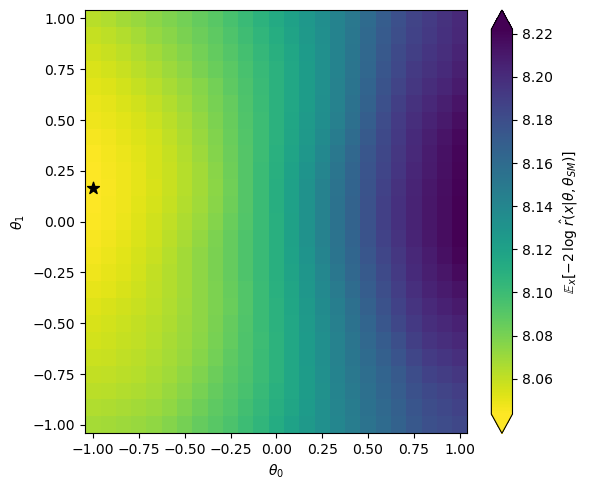

In [10]:
bin_size = theta_each[1] - theta_each[0]
edges = np.linspace(
    theta_each[0] - bin_size / 2,
    theta_each[-1] + bin_size / 2,
    len(theta_each) + 1,
)

fig = plt.figure(figsize=(6, 5))
ax = plt.gca()

expected_llr = np.mean(log_p_hat, axis=1)
best_fit = theta_grid[np.argmin(-2.0 * expected_llr)]

cmin = np.min(-2 * expected_llr)
cmax = np.max(-2 * expected_llr)

pcm = ax.pcolormesh(
    edges,
    edges,
    -2.0 * expected_llr.reshape((25, 25)),
    norm=matplotlib.colors.Normalize(vmin=cmin, vmax=cmax),
    cmap="viridis_r",
)

cbar = fig.colorbar(pcm, ax=ax, extend="both")

plt.scatter(
    best_fit[0],
    best_fit[1],
    s=80.0,
    color="black",
    marker="*",
)

plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
cbar.set_label(r"$\mathbb{E}_x [ -2\, \log \,\hat{r}(x | \theta, \theta_{SM}) ]$")

plt.tight_layout()
plt.show()

Note that in this tutorial our sample size was very small, and the network might not really have a chance to converge to the correct likelihood function. So don't worry if you find a minimum that is not at the right point (the SM, i.e. the origin in this plot). Feel free to dial up the event numbers in the run card as well as the training samples and see what happens then!